<a href="https://colab.research.google.com/github/Kartik-Patnaik/colab-condenast_bidderprediction/blob/main/Conde_Nast_Bidder_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conde Nast Bidder Prediction

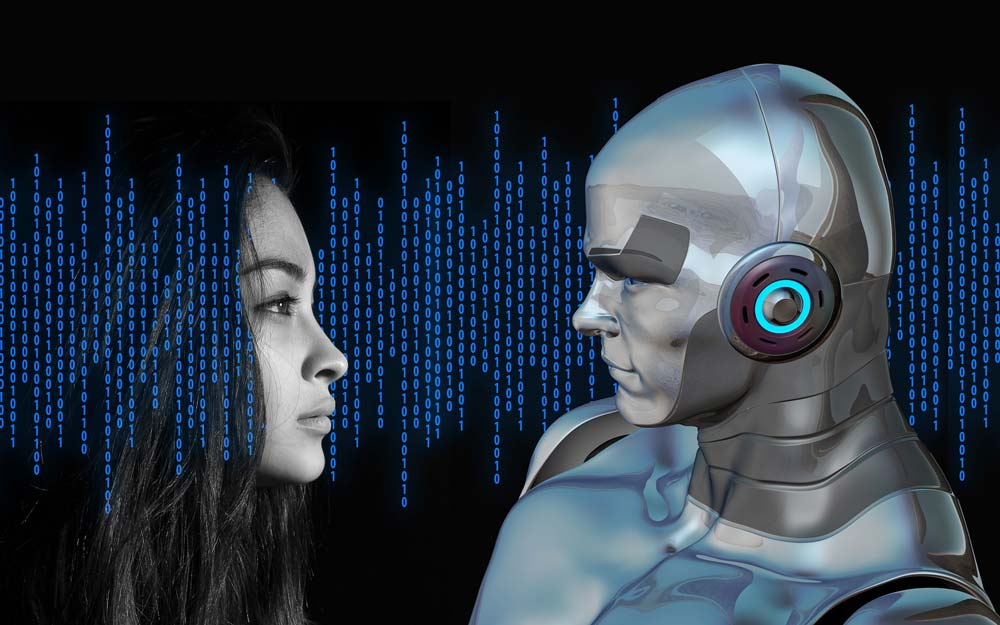#Objective:




The goal is to identify “robots” which are making bids, helping the site owners easily flag these users for removal from their site to prevent unfair auction activity.



## Importing the required Packages

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
# from ggplot import 
# ignore the warning
import warnings

In [3]:
# for feature engineering
import time
import datetime
import scipy.stats
import scipy

In [4]:
# for train and test data set split
from sklearn.model_selection import train_test_split

# for grid search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# for evaluation metric
# accuracy
from sklearn.metrics import accuracy_score
# Report
from sklearn.metrics import classification_report
# AUC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams

# for model comparision
from sklearn import metrics

In [5]:
# for decision tree model
from sklearn import tree

# for decision tree visualizaiton
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# for gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# for random search
from sklearn.ensemble import RandomForestClassifier

----
## 1 Preprocess Data
----

### 1.1 Load and Join Data

In [8]:
# load inital data
from google.colab import drive
drive.mount("/content/gdrive")
import os
os.chdir("gdrive/My Drive/DS Assignment v1")
import pandas as pd
bids = pd.read_csv("bids.csv")
train = pd.read_csv("train.csv")

Mounted at /content/gdrive


In [9]:
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [10]:
train.head()

,bidder_id,payment_account,address,robot_act_prob_lk,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,0


The datasets are provided by two part:
* `train.csv`: the base bidder dataset with labels. Besides label, it also contains unique `bidder_id` followed with `payment_account`, `address` and `outcome`;
* `bids.csv`: the dataset contains some more useful information associated with unique key `bid_id`, corresponding with `bidder_id`, `auction`, `merchandise`, `device`, `time`, `country`, `ip`, and `url`. `time` and `url` are encrypted information.

Since both of these two files contains the unique key `bidder_id`, we firstly joined these data by this key. Our object is to try to find each bid is made by a human or robot, thus, we only consider the data which have bids information and labelled. We will left join on `train.csv` and check the joined data for missing bids information.

In [11]:
# join the training data set with full data set
bid = pd.merge(train, bids, on='bidder_id', how='left')

In [12]:
# write to file
# bid.to_csv("bid.csv")

### 1.2 Load Joined Data

In [13]:
data = bid
data.head()

,bidder_id,payment_account,address,robot_act_prob_lk,outcome,bid_id,auction,merchandise,device,time,country,ip,url
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3
1,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,0,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3
2,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,0,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3
3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,0,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3
4,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,0,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3


### 1.3 Data Clean: checking missing value

In [14]:
pd.isnull(data).any()

bidder_id            False
payment_account      False
address              False
robot_act_prob_lk    False
outcome              False
bid_id                True
auction               True
merchandise           True
device                True
time                  True
country               True
ip                    True
url                   True
dtype: bool

Since we can see all the missing values are from the variables that come from `bids`, we want to check if there exist some of `bidder_id` do not have any `bid`s.

In [15]:
nobids_train = data[pd.isnull(data['bid_id'])]['bidder_id'].unique()
len(nobids_train)

24

In [16]:
data[data['bidder_id'].isin(nobids_train)]['outcome']

17583      0
42424      0
129439     0
214915     0
221776     0
226432     0
255107     0
305088     0
333331     0
409451     0
654549     0
657208     0
788183     0
790914     0
794927     0
810369     0
883351     0
1018748    0
1019599    0
1021349    0
1123023    0
1139921    0
1217466    0
1465813    0
Name: outcome, dtype: int64

There exist 29 bidder in training data set having no bid data. After checking with their labels, they were all marked as human. Since we aim to detect robot, we will just ignore them.

In [17]:
# for all the missing value observation, drop it
bid = data[~data['bidder_id'].isin(nobids_train)]

In [18]:
pd.isnull(bid).any()

bidder_id            False
payment_account      False
address              False
robot_act_prob_lk    False
outcome              False
bid_id               False
auction              False
merchandise          False
device               False
time                 False
country               True
ip                   False
url                  False
dtype: bool

In [19]:
# check the missing value ratio of the country entry
count_miss_ratio = pd.isnull(bid['country']).sum()/len(bid)*100
print(" %0.2f %% observations missing country entry." ,
      float(count_miss_ratio))

(' %0.2f %% observations missing country entry.', 0.0)


For the full data set, there is only few of observations missing country entry. We will just ignore the missing country entry data.

In [20]:
# for all the missing value observation, drop it
bid = bid.dropna()

In [21]:
# double check the missing value
pd.isnull(bid).any()

bidder_id            False
payment_account      False
address              False
robot_act_prob_lk    False
outcome              False
bid_id               False
auction              False
merchandise          False
device               False
time                 False
country              False
ip                   False
url                  False
dtype: bool

### 1.4 Data Exploration

In [22]:
print("The answer is", 2*2)

('The answer is', 4)


In [23]:
print("total row in bid: "  ,len(bid))

('total row in bid: ', 1463674)


In [24]:
# check the unique number of each feature
print("total row in bid:",          {len(bid)})
print("total bids in bid: ",        {len(bid['bid_id'].unique())})
print("total bidder in bids:",      {len(bid['bidder_id'].unique())})
print("total payment in bids:",    {len(bid['payment_account'].unique())})
print("total address in bids:",  {len(bid['address'].unique())})
print("total auction in bids:",{len(bid['auction'].unique())})
print("total merchandise in bids:", {len(bid['merchandise'].unique())})
print("total device in bids:",{len(bid['device'].unique())})
print("total country in bids:", {len(bid['country'].unique())})
print("total ip in bids:", {len(bid['ip'].unique())})
print("total url in bids:", {len(bid['url'].unique())})

('total row in bid:', set([1463674]))
('total bids in bid: ', set([1463674]))
('total bidder in bids:', set([1473]))
('total payment in bids:', set([1473]))
('total address in bids:', set([1473]))
('total auction in bids:', set([11688]))
('total merchandise in bids:', set([10]))
('total device in bids:', set([4856]))
('total country in bids:', set([187]))
('total ip in bids:', set([535182]))
('total url in bids:', set([378253]))


From this output, we can see the `payment` and `address` are one-to-one correspondence to `bidder`. Since our `outpue`, whether a bid is made from a human or robot, is label based on `bidder`, we can igonre these two features for future analysis.
Since `merchandise` and `country` are compared low in this situation, we can just treat themselves as a feature for analysis.

For the other features, let's check the ratios to robots and human. Before that, let's check the robots vs. human first.

In [25]:
print(
    "total bids made by robots in data set:", {len(bid[bid['outcome'] == 1])})
print(
    "total bids made by human in data set: ",  {len(bid[bid['outcome'] == 0])})
print("the ratio of made by robot vs. bids made by human in data set: 3:20")

('total bids made by robots in data set:', set([150219]))
('total bids made by human in data set: ', set([1313455]))
the ratio of made by robot vs. bids made by human in data set: 3:20


These trainning data set has unbalanced number of robots and human:
* we might need to do resampling before training the model.
* for the evaluation metrices, we will foucus on AUC and precision vs. recall.

Then checking the features' ratio of robots and human:

In [26]:
print("average bids per robot: %.0f" , float(len(
    bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['bidder_id'].unique())))
print("average bids per human:  %.0f",  float(len(
    bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['bidder_id'].unique())))
print("average bids per auction by robot: %.0f" , float(
    len(bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['auction'].unique())))
print("average bids per auction by human:  %.0f" , float(
    len(bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['auction'].unique())))
print("average bids per device by robot: %.0f" , float(
    len(bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['device'].unique())))
print("average bids per device by human:  %.0f" , float(
    len(bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['device'].unique())))
print("average bids per ip by robots: %.2f" , float(
    len(bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['ip'].unique())))
print("average bids per ip by human:  %.2f" , float(
    len(bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['ip'].unique())))
print("average bids per url by robot: %.2f" , float(
    len(bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['url'].unique())))
print("average bids per url by human:  %.2f" , float(
    len(bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['url'].unique())))

('average bids per robot: %.0f', 2145.0)
('average bids per human:  %.0f', 936.0)
('average bids per auction by robot: %.0f', 34.0)
('average bids per auction by human:  %.0f', 115.0)
('average bids per device by robot: %.0f', 69.0)
('average bids per device by human:  %.0f', 292.0)
('average bids per ip by robots: %.2f', 1.0)
('average bids per ip by human:  %.2f', 2.0)
('average bids per url by robot: %.2f', 4.0)
('average bids per url by human:  %.2f', 3.0)


From the above, we can see distinct difference between bids made by human and bots per auction, per device. Features related to number of bids, auction, device draw our attention.

----
## 2 Feature Engineering 
----

### 2.1 Feature Creation

In [27]:
def ent(data):
    """
    Calculate the entropy

    Parameters
    ----------
    data : dataframe
        a DataFrame containing original data

    Returns
    -------
    output: float
        computed entropy 

    Notes
    -----
    entropy is calculated with the following steps:
        1. compute the probabilities
        2. fit in the entropy formula
    """
    p_data = data.value_counts()/len(data)  # calculates the probabilities
    # input probabilities to get the entropy
    entropy = scipy.stats.entropy(p_data)
    return entropy

In [28]:
# bidding time difference per user (bidder_id)
bid = bid.sort_values(by=['time'])
bid['timediffs'] = bid.groupby('bidder_id')['time'].transform(pd.Series.diff)

# number of bids a user made per auction
bids_per_auction = bid.groupby(['auction', 'bidder_id']).size()
bids_per_auction = bids_per_auction.to_frame()

# proportion of bots for each country
pbots_country = bid[bid['outcome'] == 1].groupby(
    'country').size()/bid.groupby('country').size()
pbots_country = pbots_country.fillna(0)
pbots_country = pbots_country.to_frame()

# proportion of bots per device
pbots_device = bid[bid['outcome'] == 1].groupby(
    'device').size()/bid.groupby('device').size()
pbots_device = pbots_device.fillna(0)
pbots_device = pbots_device.to_frame()

# number of unique ip to number of bids ratio
ip_bids_ratio = bid.groupby('bidder_id')['ip'].nunique(
)/bid.groupby('bidder_id')['bid_id'].nunique()
ip_bids_ratio = ip_bids_ratio.to_frame()

# mean per auction url entropy for each user
# Input a pandas series
auction_url_entropy = bid.groupby(['auction', 'bidder_id'])['url'].apply(ent)
auction_url_entropy = auction_url_entropy.groupby(
    'bidder_id').mean().reset_index()

In [29]:
# merge the features back
bid = pd.merge(bid, bids_per_auction, on=['auction', 'bidder_id'], how='left')
bid = pd.merge(bid, pbots_country, on='country', how='left')
bid = pd.merge(bid, pbots_device, on='device', how='left')
bid = pd.merge(bid, ip_bids_ratio, on='bidder_id', how='left')
bid = pd.merge(bid, auction_url_entropy, on='bidder_id', how='left')
# set column names
bid.columns = ['Unnamed: 0', 'bidder_id', 'payment_account', 'address', 'outcome',
               'bid_id', 'auction', 'merchandise', 'device', 'time', 'country',
               'ip', 'url', 'timediffs', 'bids_per_auction', 'pbots_country', 'pbots_device',
               'ip_bids_ratio', 'auction_url_entropy']

In [30]:
bid = pd.concat([bid.iloc[:, 4], bid.iloc[:, -6:]], axis=1)

In [31]:
#bid.to_csv("featured.csv")
bid.head()

,outcome,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
0,0,NaN,368,0.017642,0.003413,0.178624,1.463760
1,1,NaN,15,0.075552,0.028097,0.327745,0.479477
2,0,NaN,2,0.150556,0.230428,0.531639,1.084777
3,0,NaN,15452,0.044114,0.056947,0.583490,0.885604
4,0,NaN,9341,0.075552,0.099914,0.640411,0.541644


In [32]:
#bid = pd.read_csv("featured.csv")
#bidk = bid.iloc[:, 1:8]

### 2.2 Data visualization

Check whether the new features could help us identify human and robots, plot the distribution of each feature of two different type of bidders.

In [33]:
warnings.filterwarnings('ignore')

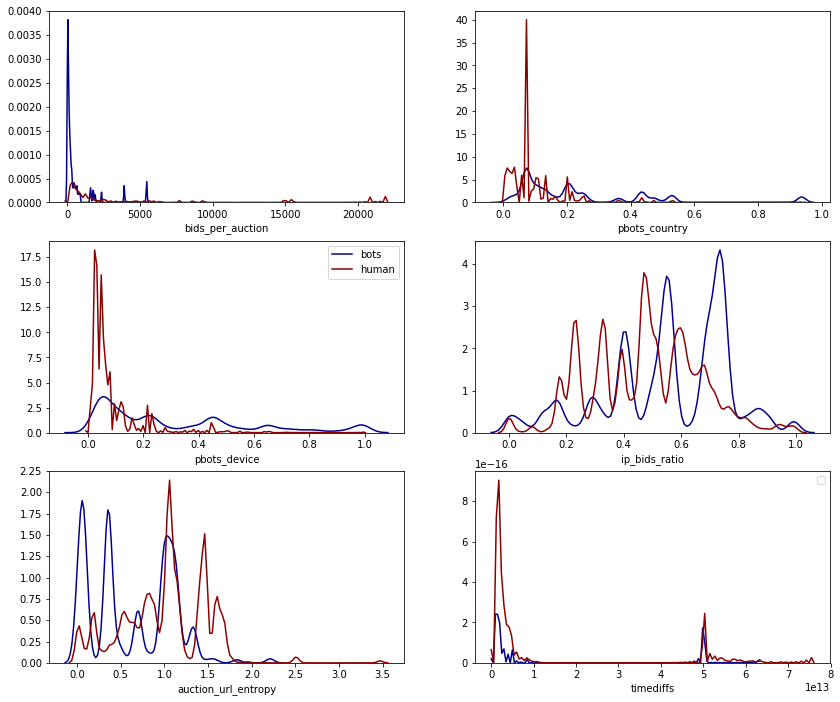

In [34]:
bots = bid.loc[bid.outcome == 1]
human = bid.loc[bid.outcome == 0]

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=False)
sns.distplot(bots['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])
sns.distplot(human['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])

sns.distplot(bots['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])
sns.distplot(human['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])

sns.distplot(bots['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkblue', label='bots',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])
sns.distplot(human['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkred', label='human',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])

sns.distplot(bots['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])
sns.distplot(human['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])

sns.distplot(bots['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])
sns.distplot(human['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])

sns.distplot(bots['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
sns.distplot(human['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
plt.legend(['bots', 'human'])
plt.show()

Since the variable `timediff` (time differ per user) showed a similar distribution between robots and human. It also has  no clearly correlation with our outcome. Therefore, this variable may not be very helpful when we are fitting a model. In contrast, we may even have overfitting problems if we incorporate it in our models. Therefore, we will ignore the variable `timediff` during the modeling process.

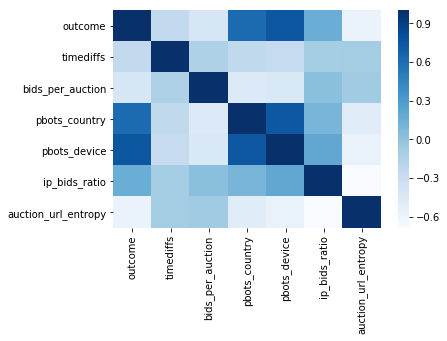

In [35]:
# Plot the correlation matrix for the numerical values
corr_matrix = bid.corr()
sns.heatmap(corr_matrix.corr(),
            xticklabels=corr_matrix.corr().columns,
            yticklabels=corr_matrix.corr().columns,
            cmap="Blues",
            fmt='d')

This plot is  the correlation matrix heatmap for our engineered features.  Dark blue in this heatmap means two variables  are highly positively correlated with each other. The white color in this heatmap indicates that two features are highly negatively correlated with each other.  From this plot, we can infer that proportion of bots per device, proportion of bots for each country and  number of unique ip to number of bids ratio are highly positively correlated with our outcome. While the mean per auction url entropy for each user are highly negatively correlated with our outcome. However, the variable time differ per user does not show clearly corrrelation with our outcome.

----
## 3. Process Imbalanced Data
----

### 3.1 Split Train and Test set

In [36]:
bid_train, bid_test = train_test_split(bid, test_size=0.2)

### 3.2 Under sampling

From data preprocessing part, we see the ratio of the robot bidder and the human bidder is 3:20, thus we need to undersampling the human bidder samples in the trainset to keep the data balance.

In [37]:
bots_train = bid_train.loc[bid_train.outcome == 1]
human_train = bid_train.loc[bid_train.outcome == 0]
human_sample = human_train.sample(n=len(bots_train))
bid_train_balance = pd.concat([bots_train, human_sample])

y_train = bid_train_balance['outcome']
X_train = bid_train_balance.iloc[:, -5:]
y_test = bid_test['outcome']
X_test = bid_test.iloc[:, -5:]

----
## 4 Modeling
----

### Base Model

Assume base model is label all data as human:

In [38]:
# base model accuracy
print(
    "base model accuracy:", {len(bid[bid['outcome'] == 0])/(len(bid[bid['outcome'] == 0])+len(bid[bid['outcome'] == 1]))})

('base model accuracy:', set([0]))


## 4.1 First Model : Decision Tree

In [39]:
# hyperparameter tuning
dt = tree.DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(10, 15),
    'min_samples_split': range(2, 6)
}

dt_cv = GridSearchCV(estimator=dt,
                     param_grid=param_grid,
                     cv=5)
dt_cv.fit(X_train, y_train)
print(dt_cv.best_params_)

{'min_samples_split': 2, 'max_leaf_nodes': 13, 'criterion': 'gini', 'max_depth': 4}


In [40]:
# fit the model
# Decision Tree
start_time = time.time()
kwargs_regularize = dict(criterion='gini',
                         max_depth=5,
                         max_leaf_nodes=14,
                         min_samples_split=2)
dt = tree.DecisionTreeClassifier(**kwargs_regularize)
dt.fit(X_train, y_train)

dt_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.339149951935 seconds ---


### 4.1.1 Tree Visualization

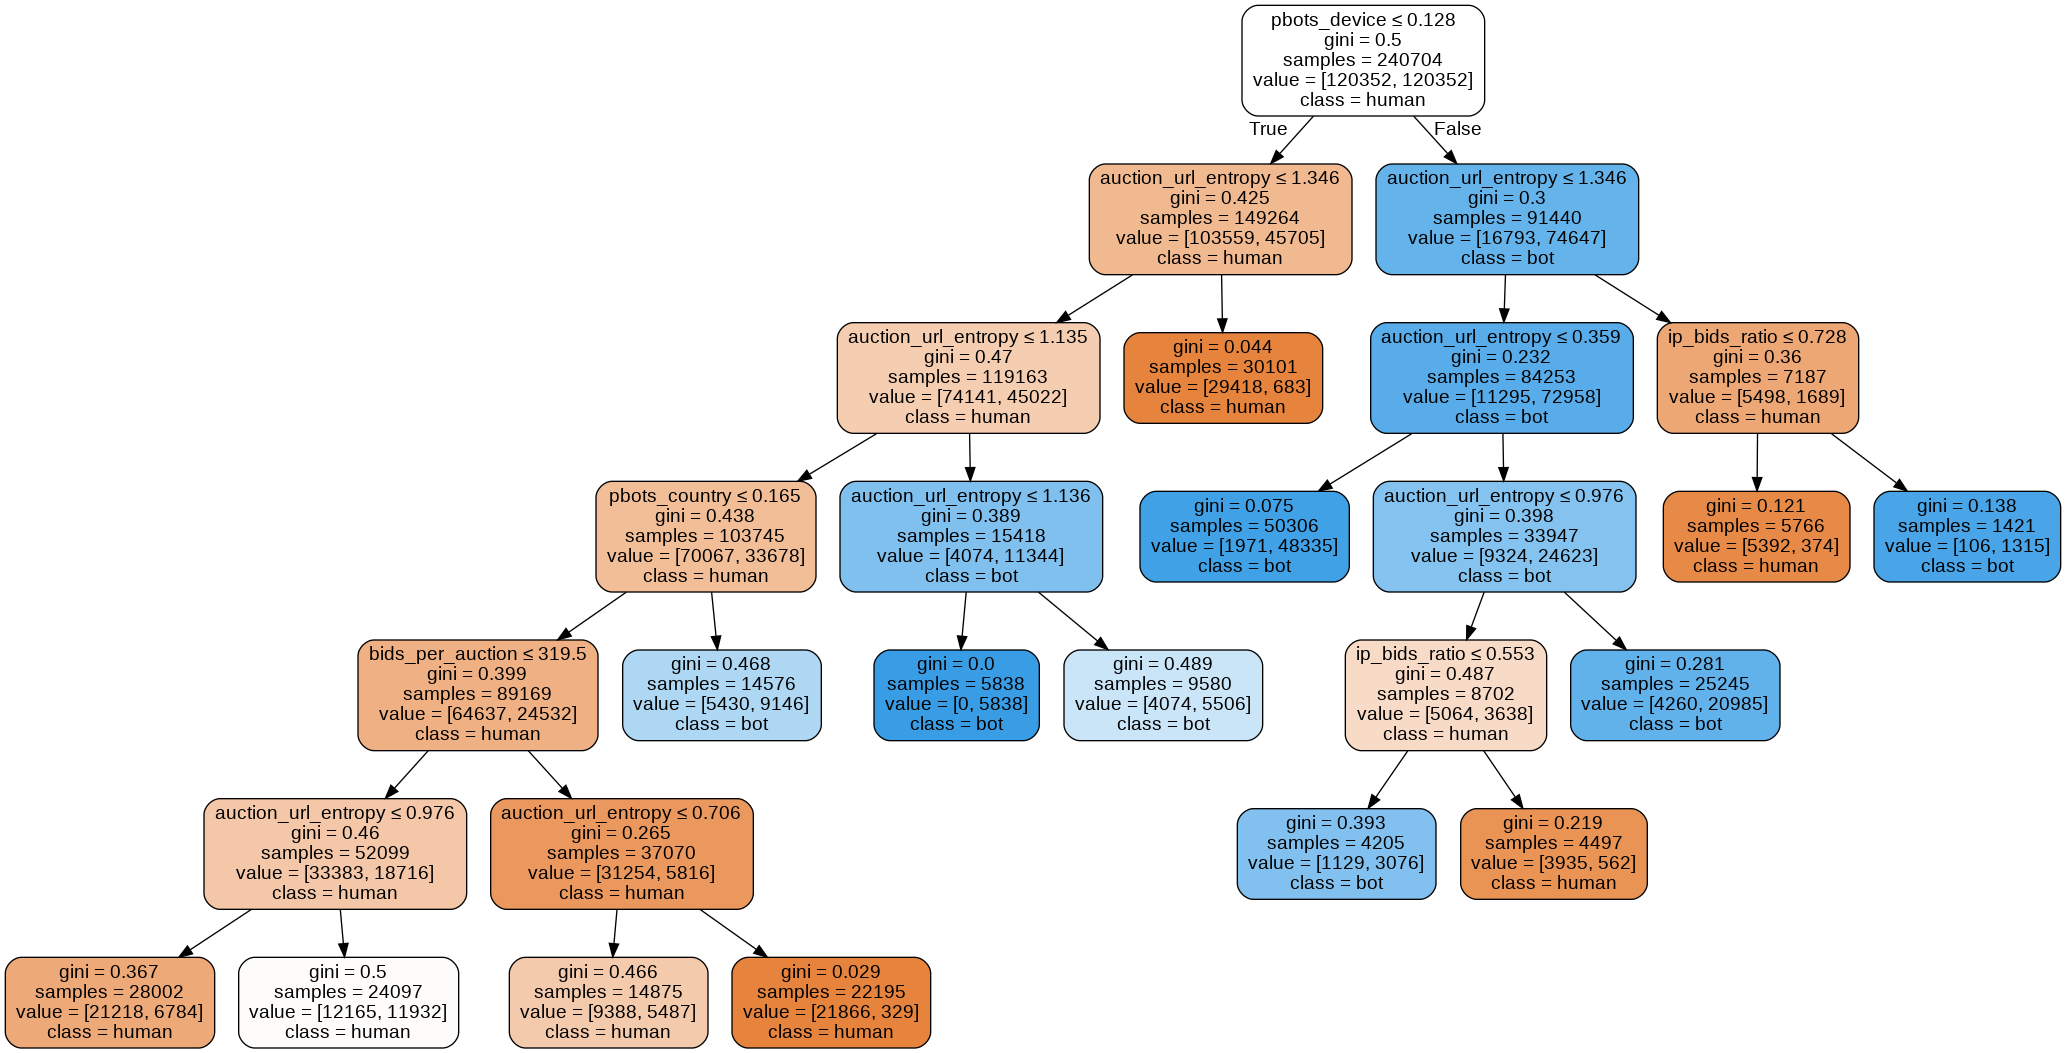

In [41]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,
                filled=True, rounded=True,
                feature_names=X_train.columns.values,
                class_names=['human', 'bot'],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [42]:
import warnings
warnings.filterwarnings('ignore')

Feature importance of Decision Tree Model


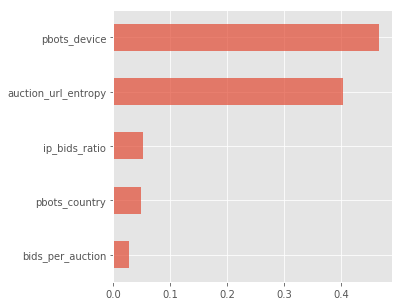

In [43]:
# Check feature importance and display in bar plot.
print('Feature importance of Decision Tree Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)


### 4.1.2 Evaluation Metric

In [44]:
# predict
y_dt_pred = dt.predict(X_test)

### 4.1.2 (1) Accuracy

In [45]:
# accuracy score
print("Decision Tree Accuracy:" , {accuracy_score(y_dt_pred, y_test)})

('Decision Tree Accuracy:', set([0.8505986643209729]))


### 4.1.2 (2) AUC

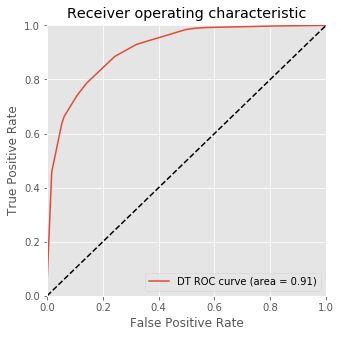

In [46]:
# Plot ROC in one graph
y_dt_score = dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _dt = roc_curve(y_test, y_dt_score)
roc_dt_auc = auc(fpr_dt, tpr_dt)

fig = plt.figure(figsize=(5, 5))
plt.plot(fpr_dt, tpr_dt, label='DT ROC curve (area = %0.2f)' % roc_dt_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


### 4.1.2 (3) Pecision vs Recall

In [47]:
print('Classification Report of Decision Tree Model')
print(classification_report(y_test, y_dt_pred))

Classification Report of Decision Tree Model
              precision    recall  f1-score   support

           0       0.97      0.86      0.91    262868
           1       0.39      0.79      0.52     29867

   micro avg       0.85      0.85      0.85    292735
   macro avg       0.68      0.82      0.71    292735
weighted avg       0.91      0.85      0.87    292735



## 4.2 Second Model: Random Forest

In [48]:
rf = RandomForestClassifier(n_estimators=50)
param_grid = {
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(8, 12),
    'max_features': ['sqrt', 'auto', 'log2']
}

rf_cv = GridSearchCV(estimator=rf,
                     param_grid=param_grid,
                     cv=5)
rf_cv.fit(X_train, y_train)
print(rf_cv.best_params_)

{'max_features': 'auto', 'max_leaf_nodes': 11, 'max_depth': 5}


In [49]:
start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, max_depth=5,
                            max_leaf_nodes=11, max_features='log2',
                            bootstrap=True, oob_score=True)
rf.fit(X_train, y_train)

rf_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 14.0550279617 seconds ---


Feature importance of Random Forest Model


IOError: ignored

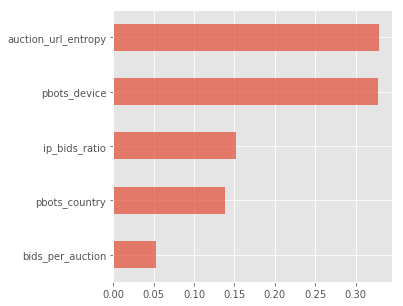

In [50]:
# Check feature importance and display in bar plot.
print('Feature importance of Random Forest Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)

### 4.2.1 Evaluation Metric

### 4.2.1 (1) Accuracy

In [51]:
y_rf_pred = rf.predict(X_test)
print("Random Forest Accuracy:", {accuracy_score(y_rf_pred, y_test)})

('Random Forest Accuracy:', set([0.9020684236596239]))


### 4.2.1 (2) AUC

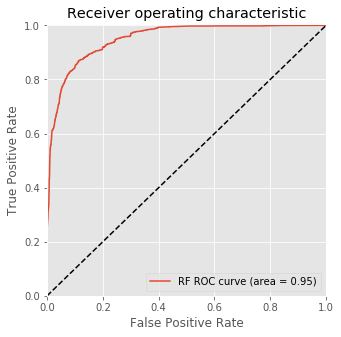

In [52]:
# Plot ROC in one graph
y_rf_score = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _rf = roc_curve(y_test, y_rf_score)
roc_rf_auc = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf, label='RF ROC curve (area = %0.2f)' % roc_rf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


### 4.2.1 (3) Precision vs. Recall

In [53]:
print('Classification Report of Random Forest Model')
print(classification_report(y_test, y_rf_pred))

Classification Report of Random Forest Model
              precision    recall  f1-score   support

           0       0.98      0.91      0.94    262868
           1       0.51      0.83      0.63     29867

   micro avg       0.90      0.90      0.90    292735
   macro avg       0.75      0.87      0.79    292735
weighted avg       0.93      0.90      0.91    292735



## 4.3 Third Model: Gradient Boosting

In [54]:
gb = GradientBoostingClassifier(n_estimators=10)
param_grid = {
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(8, 11)
}

gb_cv = GridSearchCV(estimator=gb,
                     param_grid=param_grid,
                     cv=5)
gb_cv.fit(X_train, y_train)
print(gb_cv.best_params_)

{'max_leaf_nodes': 10, 'max_depth': 5}


In [58]:
start_time = time.time()

gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, max_features='sqrt',
                                max_leaf_nodes=9)
gb.fit(X_train, y_train)

gb_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.9094560146 seconds ---


Feature importance of Gradient Boosting Model


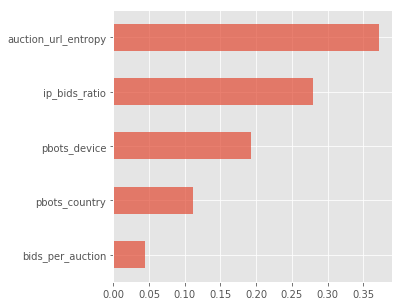

In [59]:
# Check feature importance and display in bar plot.
print('Feature importance of Gradient Boosting Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(gb.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)


### 4.3.1 Evaluation Metrics

### 4.3.1 (1) Accuracy

In [60]:
y_gb_pred = gb.predict(X_test)
print("Gradient Boosting Accuracy:" ,{accuracy_score(y_gb_pred, y_test)})

('Gradient Boosting Accuracy:', set([0.9813380702683314]))


### 4.3.1 (2) AUC

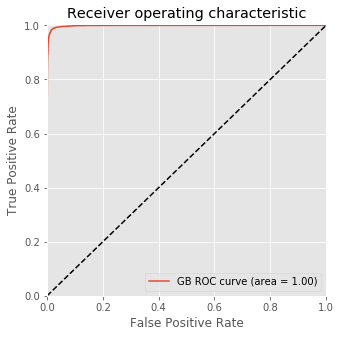

In [63]:
# Plot ROC in one graph
y_gb_score = gb.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _gb = roc_curve(y_test, y_gb_score)
roc_gb_auc = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(5, 5))
plt.plot(fpr_gb, tpr_gb, label='GB ROC curve (area = %0.2f)' % roc_gb_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 4.3.1 (3) Precison vs. Recall

In [65]:
print('Classification Report of Gradient Boosting Model')
print(classification_report(y_test, y_gb_pred))

Classification Report of Gradient Boosting Model
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    262868
           1       0.85      0.99      0.92     29867

   micro avg       0.98      0.98      0.98    292735
   macro avg       0.93      0.98      0.95    292735
weighted avg       0.98      0.98      0.98    292735



----
## 5 Compare Different Models
----

In [64]:
dt_metrics = [metrics.accuracy_score(y_test, y_dt_pred), metrics.precision_score(y_test, y_dt_pred),
              metrics.recall_score(y_test, y_dt_pred), metrics.f1_score(
                  y_test, y_dt_pred),
              metrics.roc_auc_score(y_test, y_dt_pred), dt_time]
rf_metrics = [metrics.accuracy_score(y_test, y_rf_pred), metrics.precision_score(y_test, y_rf_pred),
              metrics.recall_score(y_test, y_rf_pred), metrics.f1_score(
                  y_test, y_rf_pred),
              metrics.roc_auc_score(y_test, y_rf_pred), rf_time]
gb_metrics = [metrics.accuracy_score(y_test, y_gb_pred), metrics.precision_score(y_test, y_gb_pred),
              metrics.recall_score(y_test, y_gb_pred), metrics.f1_score(
                  y_test, y_gb_pred),
              metrics.roc_auc_score(y_test, y_gb_pred), gb_time]

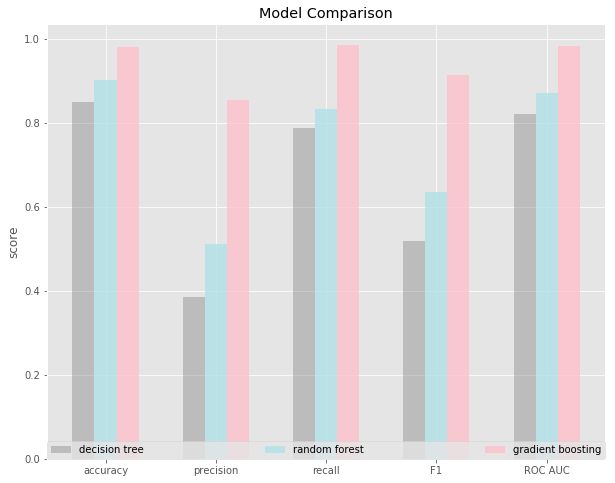

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
index = np.arange(5)
width = 0.2
b1 = plt.bar(index, dt_metrics[0:5], width,
             alpha=0.4, color='grey', label='decision tree')
b2 = plt.bar(index+width, rf_metrics[0:5], width,
             alpha=0.8, color='powderblue', label='random forest')
b3 = plt.bar(index+2*width, gb_metrics[0:5], width,
             alpha=0.8, color='pink', label='gradient boosting')
plt.title('Model Comparison')
plt.ylabel('score')
plt.xticks(index+width, ('accuracy', 'precision', 'recall', 'F1', 'ROC AUC'))
plt.legend(loc=8, ncol=3, mode="expand", borderaxespad=0.)
plt.show()


In [68]:
label = ["Accuracy_score", "Precision_score",
         "Recall_Score", "F1_score", "ROC_AUC_score", "Time(s)"]
table = pd.DataFrame({'Decision Tree': dt_metrics,
                      'Random Forest': rf_metrics, 'Gradient Boosting': gb_metrics})
table = table.transpose()
table.columns = label
table.transpose().round(3)

,Decision Tree,Gradient Boosting,Random Forest
Accuracy_score,0.851,0.981,0.902
Precision_score,0.386,0.853,0.512
Recall_Score,0.787,0.986,0.834
F1_score,0.518,0.915,0.635
ROC_AUC_score,0.822,0.984,0.872
Time(s),0.339,12.909,14.055


As we can see even though the fitting time of decision time is pretty fast, however, the preformance of it is not acceptable. The Gradient boosting model has the best performance and not cost as much time as random forest model. Thus we choose gradient boosting model as our final model.

----
## 6 Conclusion
----

From the feature importance, we can see that in the online bidding, human being are more likely come from a random url into a certain aution, however, the robots are more likely come from few specific url. And compared with human beings robots are more likely to use different ip addresses for online bidding. Thus if for a user, it using multi-ip addresses and come from few certain url, we might consider it is a robots.